## Preparation

In [1]:
import numpy as np
from sympy import *
from sympy.solvers import solve
init_printing(use_unicode=True)

def num_sym(p: int) -> int:
    return int(p * (p + 1) / 2)

def solve_lyapunov_cov(M: Matrix, C: Matrix, p: int) -> Matrix:
    Sigma = MatrixSymbol("Sigma", p, p).as_explicit()
    Sigma_solved = solve(M*Sigma + Sigma*M.T + C, Sigma)
    scheme = [[Sigma_solved[Sigma[i,j]] for i in range(p)] for j in range(p)]
    Sigma_new = Matrix(scheme)
    return Sigma_new

def create_A_Sigma(cov: Matrix, p: int) -> Matrix:
    row_num = num_sym(p=p)
    col_num = int(p * p)
    A_Sigma = MatrixSymbol("A", row_num, col_num).as_mutable()
    for l in range(p):
        for k in range(l+1):
            for i in range(p):
                for j in range(p):
                    if (j != k) & (j != l):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = 0
                    elif (j == k) & (k != l):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = cov[l, i]
                    elif (j == l) & (l != k):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = cov[k, i]
                    elif (j == k) & (j == l):
                        A_Sigma[(k * p) + (l - num_sym(p=k)), i * p + j] = 2 * cov[j, i]
    return A_Sigma

def create_A(A_Sigma: Matrix, mean: Matrix, p: int) -> Matrix:
    identity = mean[0] * eye(p)
    for i in range(1, p):
        identity = Matrix.hstack(identity, mean[i] * eye(p))
    return Matrix.vstack(A_Sigma, identity)

def create_c(vech_C: Matrix, b: float, index: int, p: int) -> Matrix:
    unit_vector = eye(p).col(index)
    return Matrix.vstack(vech_C, - b * unit_vector)

## Test 1
Estimate 1000 true matrices $M^*$, then create the matrix $A$ and vector $c$, calculate $\text{det}(A)$ and if $\text{det}(A)\neq 0$ estimate $\hat{M}$ and calculate the Frobenius distance to the true $M^*$.

In [2]:
p = 3
num_eq = num_sym(p=p) + p
num_seed = 1000
d = 0.9 # Probability of edges in graph

m11, m12, m13 = symbols('m11'), symbols('m12'), symbols('m13')
m21, m22, m23 = symbols('m21'), symbols('m22'), symbols('m23')
m31, m32, m33 = symbols('m31'), symbols('m32'), symbols('m33')
M = Matrix([[m11, m12, m13], [m21, m22, m23], [m31, m32, m33]])

C = 2 * eye(p) # volatility matrix

vec_M = Matrix([[M[j, i]] for i in range(p) for j in range(p)]) # j faster than i
vech_C = Matrix([[C[i, j]] for i in range(p) for j in range(i, p)])

# Intervention
index_intervention = 1
b = 2
unit_v = eye(p).col(index_intervention)

estimates_3nodes_test1 = np.empty(shape=(num_seed), dtype=object)
statistics_3nodes_test1 = np.empty(shape=(num_seed, 3), dtype=float)

for seed in range(1, num_seed + 1):
    np.random.seed(seed=seed)

    bernoulli_matrix = np.random.binomial(1, d, (p, p))
    normal_matrix = np.random.normal(0, 1, (p, p))

    temp_M = bernoulli_matrix * normal_matrix
    for i in range(p): # adjust diagonal entries s.t. M stable
        row_sum = np.sum(np.abs(temp_M[i, :])) - np.abs(temp_M[i, i])
        temp_M[i, i] = - row_sum - np.abs(normal_matrix[i,i])

    concrete_M = Matrix(temp_M)

    cov = solve_lyapunov_cov(M=concrete_M, C=C, p=p)
    mean = b * concrete_M.inv() * unit_v

    A_Sigma = create_A_Sigma(cov=cov, p=p)
    A = create_A(A_Sigma=A_Sigma, mean=mean, p=p)

    c = create_c(vech_C=vech_C, b=b, index=index_intervention, p=p)

    det_A = det(A)
    solution = solve(A * vec_M + c, vec_M)

    if len(solution) == 9:
        M_est = M.subs(solution)
        M_est_np = matrix2numpy(M_est).astype(float)
        M_true = matrix2numpy(concrete_M).astype(float)
        frob = np.linalg.norm(M_est_np - M_true)

        estimates_3nodes_test1[seed - 1] = M_est_np.round(3)
        statistics_3nodes_test1[seed - 1, 0] = det_A
        statistics_3nodes_test1[seed - 1, 1] = frob
        statistics_3nodes_test1[seed - 1, 2] = 1
    # elif det_A == 0: # det(A) = 0
        # print("Solution exists at seed ", seed, ": ", solution, ", but det(A)=0.")
        # statistics_3nodes_test1[seed - 1, 0] = det_A
        # statistics_3nodes_test1[seed - 1, 1] = 0.0
        # statistics_3nodes_test1[seed - 1, 2] = 0
    else: # empty solution
        estimates_3nodes_test1[seed - 1] = solution
        statistics_3nodes_test1[seed - 1, 0] = det_A
        statistics_3nodes_test1[seed - 1, 1] = 0.0
        statistics_3nodes_test1[seed - 1, 2] = 0

In [2]:
p = 3
num_eq = num_sym(p=p) + p
num_seed = 100
d = 0.9 # Probability of edges in graph

m11, m12, m13 = symbols('m11'), symbols('m12'), symbols('m13')
m21, m22, m23 = symbols('m21'), symbols('m22'), symbols('m23')
m31, m32, m33 = symbols('m31'), symbols('m32'), symbols('m33')
M = Matrix([[m11, m12, m13], [m21, m22, m23], [m31, m32, m33]])

C = 2 * eye(p) # volatility matrix

vec_M = Matrix([[M[j, i]] for i in range(p) for j in range(p)]) # j faster than i
vech_C = Matrix([[C[i, j]] for i in range(p) for j in range(i, p)])

# Intervention
index_intervention = 1
b = 2
unit_v = eye(p).col(index_intervention)

estimates_3nodes_test1 = np.empty(shape=(num_seed), dtype=object)
statistics_3nodes_test1 = np.empty(shape=(num_seed, 4), dtype=float)

for seed in range(1, num_seed + 1):
    np.random.seed(seed=seed)

    # bernoulli_matrix = np.random.binomial(1, d, (p, p))
    normal_matrix = np.random.normal(0, 1, (p, p))

    # temp_M = bernoulli_matrix * normal_matrix
    for i in range(p): # adjust diagonal entries s.t. M stable
        row_sum = np.sum(np.abs(normal_matrix[i, :])) - np.abs(normal_matrix[i, i])
        normal_matrix[i, i] = - row_sum - np.abs(normal_matrix[i,i])

    concrete_M = Matrix(normal_matrix)

    cov = solve_lyapunov_cov(M=concrete_M, C=C, p=p)
    mean = b * concrete_M.inv() * unit_v

    A_Sigma = create_A_Sigma(cov=cov, p=p)
    A = create_A(A_Sigma=A_Sigma, mean=mean, p=p)
    A_np = matrix2numpy(A).astype(float)
    rang = np.linalg.matrix_rank(A_np)

    c = create_c(vech_C=vech_C, b=b, index=index_intervention, p=p)

    det_A = det(A)
    solution = solve(A * vec_M + c, vec_M)

    if len(solution) == 9:
        M_est = M.subs(solution)
        M_est_np = matrix2numpy(M_est).astype(float)
        M_true = matrix2numpy(concrete_M).astype(float)
        frob = np.linalg.norm(M_est_np - M_true)

        estimates_3nodes_test1[seed - 1] = M_est_np.round(3)
        statistics_3nodes_test1[seed - 1, 0] = det_A
        statistics_3nodes_test1[seed - 1, 1] = frob
        statistics_3nodes_test1[seed - 1, 2] = 1
        statistics_3nodes_test1[seed - 1, 3] = rang
    # elif det_A == 0: # det(A) = 0
        # print("Solution exists at seed ", seed, ": ", solution, ", but det(A)=0.")
        # statistics_3nodes_test1[seed - 1, 0] = det_A
        # statistics_3nodes_test1[seed - 1, 1] = 0.0
        # statistics_3nodes_test1[seed - 1, 2] = 0
    else: # empty solution
        estimates_3nodes_test1[seed - 1] = solution
        statistics_3nodes_test1[seed - 1, 0] = det_A
        statistics_3nodes_test1[seed - 1, 1] = 0.0
        statistics_3nodes_test1[seed - 1, 2] = 0
        statistics_3nodes_test1[seed - 1, 3] = rang

In [ ]:
statistics_3nodes_test1

In [3]:
index_no_solution = np.where(statistics_3nodes_test1[:, 2] == 0)[0]
index_no_solution

array([219, 480])

In [4]:
statistics_3nodes_test1[index_no_solution, :]

array([[-4.25501888e-16,  0.00000000e+00,  0.00000000e+00],
       [ 4.86359419e-19,  0.00000000e+00,  0.00000000e+00]])

In [5]:
index_zero_det = np.where(statistics_3nodes_test1[:, 0] == 0)[0]
index_zero_det

array([  6,  26,  49,  59,  63,  73,  84, 121, 127, 128, 164, 186, 193,
       223, 260, 269, 283, 315, 320, 343, 345, 350, 359, 367, 370, 396,
       401, 406, 428, 432, 441, 465, 470, 488, 507, 513, 518, 544, 552,
       553, 570, 584, 601, 615, 627, 633, 635, 637, 638, 648, 662, 667,
       669, 712, 721, 722, 730, 737, 791, 809, 818, 822, 824, 859, 864,
       869, 888, 894, 899, 906, 935, 937, 980])

In [6]:
len(index_zero_det)

### Problem
There are entries that do not produce a solution even though $\text{det}(A)\neq 0$.

Solution: when solving the same system of equations but deleting an arbitrary row, the result is always the same entries dependent on $m_{33}$, so I suppose that there has to me a numerical problem behind this phenomenom.

Furthermore, there are a lot of matrices with one or several zero entries, so that cannot have been the problem (cf. $\texttt{seed = 4, 5}$).

In [7]:
np.random.seed(seed=220)

bernoulli_matrix = np.random.binomial(1, d, (p, p))
normal_matrix = np.random.normal(0, 1, (p, p))

temp_M = bernoulli_matrix * normal_matrix
for i in range(p): # adjust diagonal entries s.t. M stable
    row_sum = np.sum(np.abs(temp_M[i, :])) - np.abs(temp_M[i, i])
    temp_M[i, i] = - row_sum - np.abs(normal_matrix[i,i])

concrete_M = Matrix(temp_M)

cov = solve_lyapunov_cov(M=concrete_M, C=C, p=p)
mean = b * concrete_M.inv() * unit_v

A_Sigma = create_A_Sigma(cov=cov, p=p)
A = create_A(A_Sigma=A_Sigma, mean=mean, p=p)

c = create_c(vech_C=vech_C, b=b, index=index_intervention, p=p)

det_A = det(A)
solution = solve(A * vec_M + c, vec_M)

In [8]:
temp = A * vec_M + c
temp.row_del(8)
solve(temp, vec_M)

In [9]:
np.random.seed(seed=481)

bernoulli_matrix = np.random.binomial(1, d, (p, p))
normal_matrix = np.random.normal(0, 1, (p, p))

temp_M = bernoulli_matrix * normal_matrix
for i in range(p): # adjust diagonal entries s.t. M stable
    row_sum = np.sum(np.abs(temp_M[i, :])) - np.abs(temp_M[i, i])
    temp_M[i, i] = - row_sum - np.abs(normal_matrix[i,i])

concrete_M = Matrix(temp_M)

cov = solve_lyapunov_cov(M=concrete_M, C=C, p=p)
mean = b * concrete_M.inv() * unit_v

A_Sigma = create_A_Sigma(cov=cov, p=p)
A = create_A(A_Sigma=A_Sigma, mean=mean, p=p)

c = create_c(vech_C=vech_C, b=b, index=index_intervention, p=p)

det_A = det(A)
solution = solve(A * vec_M + c, vec_M)

In [10]:
temp = A * vec_M + c
temp.row_del(0)
solve(temp, vec_M)

### How do the estimates look and what can we say about them?

Significant amount of matrices that produce $\text{det}(A) = 0$ have non-zero entries everywhere.

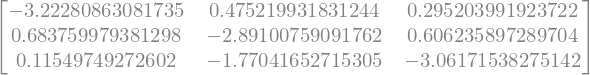

In [11]:
np.random.seed(seed=824+1)

bernoulli_matrix = np.random.binomial(1, d, (p, p))
normal_matrix = np.random.normal(0, 1, (p, p))

temp_M = bernoulli_matrix * normal_matrix
for i in range(p): # adjust diagonal entries s.t. M stable
    row_sum = np.sum(np.abs(temp_M[i, :])) - np.abs(temp_M[i, i])
    temp_M[i, i] = - row_sum - np.abs(normal_matrix[i,i])

concrete_M = Matrix(temp_M)
concrete_M

## Test 2
How changes the number of unsuccessful estimations (no solution) and of successful estimations in spite of having $\text{det}(A)=0$ in correlation with the mean number of edges in the graph?

Our baseline is always 750 executions of the experiment.

### Probability of 99%
$\mathbb{P}(\text{edge}) = 99\%$, therefore on average there are $\mathbb{E}(\text{number of edges})=0.99*6=5.94$ edges plus the $3$ self-loops in the graph.

***Results:*** $\texttt{seed = 480,711}$ unsuccessful estimations and $\large{54}$ estimations in spite of having $\text{det}(A)=0$.

In [12]:
p = 3
num_eq = num_sym(p=p) + p
num_seed = 750
d = 0.99 # Probability of edges in graph

m11, m12, m13 = symbols('m11'), symbols('m12'), symbols('m13')
m21, m22, m23 = symbols('m21'), symbols('m22'), symbols('m23')
m31, m32, m33 = symbols('m31'), symbols('m32'), symbols('m33')
M = Matrix([[m11, m12, m13], [m21, m22, m23], [m31, m32, m33]])

C = 2 * eye(p) # volatility matrix

vec_M = Matrix([[M[j, i]] for i in range(p) for j in range(p)]) # j faster than i
vech_C = Matrix([[C[i, j]] for i in range(p) for j in range(i, p)])

# Intervention
index_intervention = 1
b = 2
unit_v = eye(p).col(index_intervention)

estimates_3nodes_test2_99 = np.empty(shape=(num_seed), dtype=object)
statistics_3nodes_test2_99 = np.empty(shape=(num_seed, 3), dtype=float)

for seed in range(1, num_seed + 1):
    np.random.seed(seed=seed)

    bernoulli_matrix = np.random.binomial(1, d, (p, p))
    normal_matrix = np.random.normal(0, 1, (p, p))

    temp_M = bernoulli_matrix * normal_matrix
    for i in range(p): # adjust diagonal entries s.t. M stable
        row_sum = np.sum(np.abs(temp_M[i, :])) - np.abs(temp_M[i, i])
        temp_M[i, i] = - row_sum - np.abs(normal_matrix[i,i])

    concrete_M = Matrix(temp_M)

    cov = solve_lyapunov_cov(M=concrete_M, C=C, p=p)
    mean = b * concrete_M.inv() * unit_v

    A_Sigma = create_A_Sigma(cov=cov, p=p)
    A = create_A(A_Sigma=A_Sigma, mean=mean, p=p)

    c = create_c(vech_C=vech_C, b=b, index=index_intervention, p=p)

    det_A = det(A)
    solution = solve(A * vec_M + c, vec_M)

    if len(solution) == 9:
        M_est = M.subs(solution)
        M_est_np = matrix2numpy(M_est).astype(float)
        M_true = matrix2numpy(concrete_M).astype(float)
        frob = np.linalg.norm(M_est_np - M_true)

        estimates_3nodes_test2_99[seed - 1] = M_est_np.round(3)
        statistics_3nodes_test2_99[seed - 1, 0] = det_A
        statistics_3nodes_test2_99[seed - 1, 1] = frob
        statistics_3nodes_test2_99[seed - 1, 2] = 1
    else: # empty solution
        estimates_3nodes_test2_99[seed - 1] = solution
        statistics_3nodes_test2_99[seed - 1, 0] = det_A
        statistics_3nodes_test2_99[seed - 1, 1] = 0.0
        statistics_3nodes_test2_99[seed - 1, 2] = 0

In [13]:
index_no_solution_99 = np.where(statistics_3nodes_test2_99[:, 2] == 0)[0]
index_no_solution_99

array([480, 711])

In [14]:
statistics_3nodes_test2_99[index_no_solution_99, :]

array([[ 4.86359419e-19,  0.00000000e+00,  0.00000000e+00],
       [-2.20993087e-18,  0.00000000e+00,  0.00000000e+00]])

In [15]:
index_zero_det_99 = np.where(statistics_3nodes_test2_99[:, 0] == 0)[0]
index_zero_det_99

array([  6,  17,  49,  59,  60,  63,  73,  84, 121, 127, 146, 148, 164,
       186, 193, 215, 223, 225, 274, 283, 315, 343, 345, 348, 367, 370,
       403, 406, 428, 432, 441, 449, 470, 482, 493, 507, 509, 518, 520,
       522, 544, 553, 554, 570, 601, 633, 635, 662, 667, 669, 676, 687,
       692, 747])

In [16]:
len(index_zero_det_99)

### Probability of 90%
$\mathbb{P}(\text{edge}) = 90\%$, therefore on average there are $\mathbb{E}(\text{number of edges})=0.9*6=5.4$ edges plus the $3$ self-loops in the graph (cf. Test 1).

***Results:*** $\texttt{seed = 219,480}$ unsuccessful estimations and $\large{58}$ estimations in spite of having $\text{det}(A)=0$.

### Probability of 80%
$\mathbb{P}(\text{edge}) = 80\%$, therefore on average there are $\mathbb{E}(\text{number of edges})=0.8*6=4.8$ edges plus the $3$ self-loops in the graph.

***Results:*** $\texttt{seed = 219,480,745}$ unsuccessful estimations and $\large{56}$ estimations in spite of having $\text{det}(A)=0$.

In [17]:
p = 3
num_eq = num_sym(p=p) + p
num_seed = 750
d = 0.8 # Probability of edges in graph

m11, m12, m13 = symbols('m11'), symbols('m12'), symbols('m13')
m21, m22, m23 = symbols('m21'), symbols('m22'), symbols('m23')
m31, m32, m33 = symbols('m31'), symbols('m32'), symbols('m33')
M = Matrix([[m11, m12, m13], [m21, m22, m23], [m31, m32, m33]])

C = 2 * eye(p) # volatility matrix

vec_M = Matrix([[M[j, i]] for i in range(p) for j in range(p)]) # j faster than i
vech_C = Matrix([[C[i, j]] for i in range(p) for j in range(i, p)])

# Intervention
index_intervention = 1
b = 2
unit_v = eye(p).col(index_intervention)

estimates_3nodes_test2_80 = np.empty(shape=(num_seed), dtype=object)
statistics_3nodes_test2_80 = np.empty(shape=(num_seed, 3), dtype=float)

for seed in range(1, num_seed + 1):
    np.random.seed(seed=seed)

    bernoulli_matrix = np.random.binomial(1, d, (p, p))
    normal_matrix = np.random.normal(0, 1, (p, p))

    temp_M = bernoulli_matrix * normal_matrix
    for i in range(p): # adjust diagonal entries s.t. M stable
        row_sum = np.sum(np.abs(temp_M[i, :])) - np.abs(temp_M[i, i])
        temp_M[i, i] = - row_sum - np.abs(normal_matrix[i,i])

    concrete_M = Matrix(temp_M)

    cov = solve_lyapunov_cov(M=concrete_M, C=C, p=p)
    mean = b * concrete_M.inv() * unit_v

    A_Sigma = create_A_Sigma(cov=cov, p=p)
    A = create_A(A_Sigma=A_Sigma, mean=mean, p=p)

    c = create_c(vech_C=vech_C, b=b, index=index_intervention, p=p)

    det_A = det(A)
    solution = solve(A * vec_M + c, vec_M)

    if len(solution) == 9:
        M_est = M.subs(solution)
        M_est_np = matrix2numpy(M_est).astype(float)
        M_true = matrix2numpy(concrete_M).astype(float)
        frob = np.linalg.norm(M_est_np - M_true)

        estimates_3nodes_test2_80[seed - 1] = M_est_np.round(3)
        statistics_3nodes_test2_80[seed - 1, 0] = det_A
        statistics_3nodes_test2_80[seed - 1, 1] = frob
        statistics_3nodes_test2_80[seed - 1, 2] = 1
    else: # empty solution
        estimates_3nodes_test2_80[seed - 1] = solution
        statistics_3nodes_test2_80[seed - 1, 0] = det_A
        statistics_3nodes_test2_80[seed - 1, 1] = 0.0
        statistics_3nodes_test2_80[seed - 1, 2] = 0

In [18]:
index_no_solution_80 = np.where(statistics_3nodes_test2_80[:, 2] == 0)[0]
index_no_solution_80

array([219, 480, 745])

In [19]:
statistics_3nodes_test2_80[index_no_solution_80, :]

array([[-4.25501888e-16,  0.00000000e+00,  0.00000000e+00],
       [ 4.86359419e-19,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [20]:
index_zero_det_80 = np.where(statistics_3nodes_test2_80[:, 0] == 0)[0]
index_zero_det_80

array([  6,  49,  59,  60,  63,  69,  73,  84, 103, 121, 193, 223, 241,
       244, 286, 315, 330, 333, 343, 345, 350, 356, 359, 377, 396, 401,
       406, 423, 432, 437, 447, 478, 510, 518, 544, 553, 584, 599, 601,
       615, 618, 619, 627, 637, 642, 652, 662, 667, 669, 712, 722, 727,
       730, 737, 739, 745])

In [21]:
len(index_zero_det_80)

### Probability of 70%
$\mathbb{P}(\text{edge}) = 70\%$, therefore on average there are $\mathbb{E}(\text{number of edges})=0.7*6=4.2$ edges plus the $3$ self-loops in the graph.

***Results:*** $\large{20}$ unsuccessful estimations and $\large{75}$ estimations in spite of having $\text{det}(A)=0$.

In [22]:
p = 3
num_eq = num_sym(p=p) + p
num_seed = 750
d = 0.7 # Probability of edges in graph

m11, m12, m13 = symbols('m11'), symbols('m12'), symbols('m13')
m21, m22, m23 = symbols('m21'), symbols('m22'), symbols('m23')
m31, m32, m33 = symbols('m31'), symbols('m32'), symbols('m33')
M = Matrix([[m11, m12, m13], [m21, m22, m23], [m31, m32, m33]])

C = 2 * eye(p) # volatility matrix

vec_M = Matrix([[M[j, i]] for i in range(p) for j in range(p)]) # j faster than i
vech_C = Matrix([[C[i, j]] for i in range(p) for j in range(i, p)])

# Intervention
index_intervention = 1
b = 2
unit_v = eye(p).col(index_intervention)

estimates_3nodes_test2_70 = np.empty(shape=(num_seed), dtype=object)
statistics_3nodes_test2_70 = np.empty(shape=(num_seed, 3), dtype=float)

for seed in range(1, num_seed + 1):
    np.random.seed(seed=seed)

    bernoulli_matrix = np.random.binomial(1, d, (p, p))
    normal_matrix = np.random.normal(0, 1, (p, p))

    temp_M = bernoulli_matrix * normal_matrix
    for i in range(p): # adjust diagonal entries s.t. M stable
        row_sum = np.sum(np.abs(temp_M[i, :])) - np.abs(temp_M[i, i])
        temp_M[i, i] = - row_sum - np.abs(normal_matrix[i,i])

    concrete_M = Matrix(temp_M)

    cov = solve_lyapunov_cov(M=concrete_M, C=C, p=p)
    mean = b * concrete_M.inv() * unit_v

    A_Sigma = create_A_Sigma(cov=cov, p=p)
    A = create_A(A_Sigma=A_Sigma, mean=mean, p=p)

    c = create_c(vech_C=vech_C, b=b, index=index_intervention, p=p)

    det_A = det(A)
    solution = solve(A * vec_M + c, vec_M)

    if len(solution) == 9:
        M_est = M.subs(solution)
        M_est_np = matrix2numpy(M_est).astype(float)
        M_true = matrix2numpy(concrete_M).astype(float)
        frob = np.linalg.norm(M_est_np - M_true)

        estimates_3nodes_test2_70[seed - 1] = M_est_np.round(3)
        statistics_3nodes_test2_70[seed - 1, 0] = det_A
        statistics_3nodes_test2_70[seed - 1, 1] = frob
        statistics_3nodes_test2_70[seed - 1, 2] = 1
    else: # empty solution
        estimates_3nodes_test2_70[seed - 1] = solution
        statistics_3nodes_test2_70[seed - 1, 0] = det_A
        statistics_3nodes_test2_70[seed - 1, 1] = 0.0
        statistics_3nodes_test2_70[seed - 1, 2] = 0

In [23]:
index_no_solution_70 = np.where(statistics_3nodes_test2_70[:, 2] == 0)[0]
index_no_solution_70

array([ 26,  30,  49,  70, 196, 219, 222, 235, 239, 286, 447, 449, 453,
       467, 642, 648, 654, 657, 739, 745])

In [24]:
statistics_3nodes_test2_70[index_no_solution_70, :]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.20428620e-18,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.25501888e-16,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00

In [25]:
index_zero_det_70 = np.where(statistics_3nodes_test2_70[:, 0] == 0)[0]
index_zero_det_70

array([ 13,  17,  26,  28,  30,  59,  60,  63,  69,  70,  71,  84, 116,
       150, 162, 163, 196, 203, 217, 218, 222, 235, 239, 241, 244, 257,
       260, 286, 289, 320, 345, 350, 356, 359, 377, 395, 396, 401, 406,
       410, 431, 432, 437, 447, 449, 453, 467, 478, 518, 531, 533, 553,
       579, 584, 599, 601, 615, 618, 619, 627, 642, 648, 652, 654, 657,
       662, 669, 675, 692, 727, 730, 734, 737, 739, 745])

In [26]:
len(index_zero_det_70)

### Probability 60%
$\mathbb{P}(\text{edge}) = 60\%$, therefore on average there are $\mathbb{E}(\text{number of edges})=0.6*6=3.6$ edges plus the $3$ self-loops in the graph.

***Results:*** $\large{55}$ unsuccessful estimations and $\large{103}$ estimations in spite of having $\text{det}(A)=0$.

In [27]:
p = 3
num_eq = num_sym(p=p) + p
num_seed = 750
d = 0.6 # Probability of edges in graph

m11, m12, m13 = symbols('m11'), symbols('m12'), symbols('m13')
m21, m22, m23 = symbols('m21'), symbols('m22'), symbols('m23')
m31, m32, m33 = symbols('m31'), symbols('m32'), symbols('m33')
M = Matrix([[m11, m12, m13], [m21, m22, m23], [m31, m32, m33]])

C = 2 * eye(p) # volatility matrix

vec_M = Matrix([[M[j, i]] for i in range(p) for j in range(p)]) # j faster than i
vech_C = Matrix([[C[i, j]] for i in range(p) for j in range(i, p)])

# Intervention
index_intervention = 1
b = 2
unit_v = eye(p).col(index_intervention)

estimates_3nodes_test2_60 = np.empty(shape=(num_seed), dtype=object)
statistics_3nodes_test2_60 = np.empty(shape=(num_seed, 3), dtype=float)

for seed in range(1, num_seed + 1):
    np.random.seed(seed=seed)

    bernoulli_matrix = np.random.binomial(1, d, (p, p))
    normal_matrix = np.random.normal(0, 1, (p, p))

    temp_M = bernoulli_matrix * normal_matrix
    for i in range(p): # adjust diagonal entries s.t. M stable
        row_sum = np.sum(np.abs(temp_M[i, :])) - np.abs(temp_M[i, i])
        temp_M[i, i] = - row_sum - np.abs(normal_matrix[i,i])

    concrete_M = Matrix(temp_M)

    cov = solve_lyapunov_cov(M=concrete_M, C=C, p=p)
    mean = b * concrete_M.inv() * unit_v

    A_Sigma = create_A_Sigma(cov=cov, p=p)
    A = create_A(A_Sigma=A_Sigma, mean=mean, p=p)

    c = create_c(vech_C=vech_C, b=b, index=index_intervention, p=p)

    det_A = det(A)
    solution = solve(A * vec_M + c, vec_M)

    if len(solution) == 9:
        M_est = M.subs(solution)
        M_est_np = matrix2numpy(M_est).astype(float)
        M_true = matrix2numpy(concrete_M).astype(float)
        frob = np.linalg.norm(M_est_np - M_true)

        estimates_3nodes_test2_60[seed - 1] = M_est_np.round(3)
        statistics_3nodes_test2_60[seed - 1, 0] = det_A
        statistics_3nodes_test2_60[seed - 1, 1] = frob
        statistics_3nodes_test2_60[seed - 1, 2] = 1
    else: # empty solution
        estimates_3nodes_test2_60[seed - 1] = solution
        statistics_3nodes_test2_60[seed - 1, 0] = det_A
        statistics_3nodes_test2_60[seed - 1, 1] = 0.0
        statistics_3nodes_test2_60[seed - 1, 2] = 0

In [28]:
index_no_solution_60 = np.where(statistics_3nodes_test2_60[:, 2] == 0)[0]
index_no_solution_60

array([ 17,  26,  30,  49,  70,  73,  77,  81,  92, 105, 109, 114, 119,
       121, 133, 153, 161, 189, 196, 216, 221, 222, 226, 233, 235, 239,
       266, 286, 294, 324, 329, 330, 409, 447, 448, 449, 453, 455, 461,
       467, 479, 486, 528, 595, 642, 648, 653, 654, 657, 697, 719, 728,
       732, 739, 745])

In [29]:
statistics_3nodes_test2_60[index_no_solution_60, :]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.20428620e-18,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 9.13631195e-17,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.89541680e-14,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00

In [30]:
index_zero_det_60 = np.where(statistics_3nodes_test2_60[:, 0] == 0)[0]
index_zero_det_60

array([ 13,  17,  26,  28,  30,  63,  69,  70,  73,  77,  81,  92,  99,
       105, 109, 116, 119, 133, 141, 150, 153, 161, 162, 163, 185, 189,
       196, 202, 204, 214, 216, 218, 221, 222, 226, 233, 235, 239, 241,
       243, 244, 253, 266, 273, 286, 289, 290, 294, 320, 324, 329, 330,
       350, 372, 377, 401, 405, 406, 409, 431, 447, 448, 449, 453, 455,
       461, 467, 468, 478, 479, 486, 528, 533, 538, 563, 567, 571, 595,
       599, 607, 615, 619, 627, 642, 643, 648, 652, 653, 654, 657, 668,
       669, 692, 696, 697, 719, 727, 728, 730, 732, 737, 739, 745])

In [31]:
len(index_zero_det_60)

### Probability 50%
$\mathbb{P}(\text{edge}) = 50\%$, therefore on average there are $\mathbb{E}(\text{number of edges})=0.5*6=3$ edges plus the $3$ self-loops in the graph.

***Results:*** $\large{129}$ unsuccessful estimations and $\large{185}$ estimations in spite of having $\text{det}(A)=0$.

In [32]:
p = 3
num_eq = num_sym(p=p) + p
num_seed = 750
d = 0.5 # Probability of edges in graph

m11, m12, m13 = symbols('m11'), symbols('m12'), symbols('m13')
m21, m22, m23 = symbols('m21'), symbols('m22'), symbols('m23')
m31, m32, m33 = symbols('m31'), symbols('m32'), symbols('m33')
M = Matrix([[m11, m12, m13], [m21, m22, m23], [m31, m32, m33]])

C = 2 * eye(p) # volatility matrix

vec_M = Matrix([[M[j, i]] for i in range(p) for j in range(p)]) # j faster than i
vech_C = Matrix([[C[i, j]] for i in range(p) for j in range(i, p)])

# Intervention
index_intervention = 1
b = 2
unit_v = eye(p).col(index_intervention)

estimates_3nodes_test2_50 = np.empty(shape=(num_seed), dtype=object)
statistics_3nodes_test2_50 = np.empty(shape=(num_seed, 3), dtype=float)

for seed in range(1, num_seed + 1):
    np.random.seed(seed=seed)

    bernoulli_matrix = np.random.binomial(1, d, (p, p))
    normal_matrix = np.random.normal(0, 1, (p, p))

    temp_M = bernoulli_matrix * normal_matrix
    for i in range(p): # adjust diagonal entries s.t. M stable
        row_sum = np.sum(np.abs(temp_M[i, :])) - np.abs(temp_M[i, i])
        temp_M[i, i] = - row_sum - np.abs(normal_matrix[i,i])

    concrete_M = Matrix(temp_M)

    cov = solve_lyapunov_cov(M=concrete_M, C=C, p=p)
    mean = b * concrete_M.inv() * unit_v

    A_Sigma = create_A_Sigma(cov=cov, p=p)
    A = create_A(A_Sigma=A_Sigma, mean=mean, p=p)

    c = create_c(vech_C=vech_C, b=b, index=index_intervention, p=p)

    det_A = det(A)
    solution = solve(A * vec_M + c, vec_M)

    if len(solution) == 9:
        M_est = M.subs(solution)
        M_est_np = matrix2numpy(M_est).astype(float)
        M_true = matrix2numpy(concrete_M).astype(float)
        frob = np.linalg.norm(M_est_np - M_true)

        estimates_3nodes_test2_50[seed - 1] = M_est_np.round(3)
        statistics_3nodes_test2_50[seed - 1, 0] = det_A
        statistics_3nodes_test2_50[seed - 1, 1] = frob
        statistics_3nodes_test2_50[seed - 1, 2] = 1
    else: # empty solution
        estimates_3nodes_test2_50[seed - 1] = solution
        statistics_3nodes_test2_50[seed - 1, 0] = det_A
        statistics_3nodes_test2_50[seed - 1, 1] = 0.0
        statistics_3nodes_test2_50[seed - 1, 2] = 0

In [33]:
index_no_solution_50 = np.where(statistics_3nodes_test2_50[:, 2] == 0)[0]
index_no_solution_50

array([  0,   8,  10,  14,  29,  32,  34,  44,  49,  57,  59,  61,  67,
        68,  83,  88,  97, 104, 110, 118, 125, 130, 132, 135, 137, 139,
       142, 147, 151, 154, 158, 159, 179, 180, 190, 191, 206, 207, 211,
       213, 218, 223, 254, 255, 263, 269, 279, 280, 281, 285, 288, 306,
       311, 314, 317, 321, 328, 332, 336, 341, 345, 361, 368, 377, 390,
       394, 397, 399, 404, 406, 408, 415, 419, 432, 444, 446, 454, 468,
       471, 475, 480, 504, 505, 511, 512, 516, 519, 532, 534, 535, 536,
       543, 549, 559, 564, 571, 578, 583, 585, 590, 591, 593, 606, 621,
       623, 624, 626, 633, 641, 647, 649, 656, 662, 664, 669, 672, 679,
       686, 703, 710, 713, 723, 727, 730, 733, 744, 746, 747, 748])

In [34]:
statistics_3nodes_test2_50[index_no_solution_50, :]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00

In [35]:
index_zero_det_50 = np.where(statistics_3nodes_test2_50[:, 0] == 0)[0]
index_zero_det_50

array([  0,   6,   8,  10,  14,  16,  17,  29,  31,  32,  34,  44,  45,
        49,  54,  57,  58,  59,  61,  63,  64,  67,  68,  83,  88,  96,
        97, 104, 110, 118, 125, 129, 130, 132, 135, 137, 138, 139, 142,
       143, 147, 151, 154, 158, 159, 177, 179, 180, 188, 190, 191, 202,
       206, 207, 208, 209, 211, 213, 218, 223, 224, 227, 254, 255, 256,
       257, 260, 263, 269, 279, 280, 281, 284, 285, 286, 288, 306, 311,
       314, 317, 320, 321, 328, 332, 336, 341, 342, 345, 361, 366, 368,
       377, 390, 394, 397, 399, 402, 404, 406, 408, 413, 415, 419, 432,
       444, 446, 449, 454, 465, 468, 471, 475, 483, 488, 503, 504, 505,
       509, 511, 512, 516, 519, 532, 534, 535, 536, 538, 539, 543, 545,
       549, 554, 557, 559, 563, 564, 570, 571, 582, 583, 585, 588, 590,
       591, 593, 601, 606, 612, 616, 620, 621, 623, 624, 626, 633, 639,
       641, 646, 647, 656, 662, 664, 669, 670, 672, 678, 679, 684, 685,
       686, 688, 702, 703, 705, 710, 713, 723, 727, 730, 733, 73

In [36]:
len(index_zero_det_50)

### Probability 40%
$\mathbb{P}(\text{edge}) = 40\%$, therefore on average there are $\mathbb{E}(\text{number of edges})=0.4*6=2.4$ edges plus the $3$ self-loops in the graph.

***Results:*** $\large{234}$ unsuccessful estimations and $\large{276}$ estimations in spite of having $\text{det}(A)=0$.

In [37]:
p = 3
num_eq = num_sym(p=p) + p
num_seed = 750
d = 0.4 # Probability of edges in graph

m11, m12, m13 = symbols('m11'), symbols('m12'), symbols('m13')
m21, m22, m23 = symbols('m21'), symbols('m22'), symbols('m23')
m31, m32, m33 = symbols('m31'), symbols('m32'), symbols('m33')
M = Matrix([[m11, m12, m13], [m21, m22, m23], [m31, m32, m33]])

C = 2 * eye(p) # volatility matrix

vec_M = Matrix([[M[j, i]] for i in range(p) for j in range(p)]) # j faster than i
vech_C = Matrix([[C[i, j]] for i in range(p) for j in range(i, p)])

# Intervention
index_intervention = 1
b = 2
unit_v = eye(p).col(index_intervention)

estimates_3nodes_test2_40 = np.empty(shape=(num_seed), dtype=object)
statistics_3nodes_test2_40 = np.empty(shape=(num_seed, 3), dtype=float)

for seed in range(1, num_seed + 1):
    np.random.seed(seed=seed)

    bernoulli_matrix = np.random.binomial(1, d, (p, p))
    normal_matrix = np.random.normal(0, 1, (p, p))

    temp_M = bernoulli_matrix * normal_matrix
    for i in range(p): # adjust diagonal entries s.t. M stable
        row_sum = np.sum(np.abs(temp_M[i, :])) - np.abs(temp_M[i, i])
        temp_M[i, i] = - row_sum - np.abs(normal_matrix[i,i])

    concrete_M = Matrix(temp_M)

    cov = solve_lyapunov_cov(M=concrete_M, C=C, p=p)
    mean = b * concrete_M.inv() * unit_v

    A_Sigma = create_A_Sigma(cov=cov, p=p)
    A = create_A(A_Sigma=A_Sigma, mean=mean, p=p)

    c = create_c(vech_C=vech_C, b=b, index=index_intervention, p=p)

    det_A = det(A)
    solution = solve(A * vec_M + c, vec_M)

    if len(solution) == 9:
        M_est = M.subs(solution)
        M_est_np = matrix2numpy(M_est).astype(float)
        M_true = matrix2numpy(concrete_M).astype(float)
        frob = np.linalg.norm(M_est_np - M_true)

        estimates_3nodes_test2_40[seed - 1] = M_est_np.round(3)
        statistics_3nodes_test2_40[seed - 1, 0] = det_A
        statistics_3nodes_test2_40[seed - 1, 1] = frob
        statistics_3nodes_test2_40[seed - 1, 2] = 1
    else: # empty solution
        estimates_3nodes_test2_40[seed - 1] = solution
        statistics_3nodes_test2_40[seed - 1, 0] = det_A
        statistics_3nodes_test2_40[seed - 1, 1] = 0.0
        statistics_3nodes_test2_40[seed - 1, 2] = 0

In [38]:
index_no_solution_40 = np.where(statistics_3nodes_test2_40[:, 2] == 0)[0]
index_no_solution_40

array([  0,   1,   5,   6,   8,  10,  14,  15,  24,  27,  29,  32,  34,
        36,  44,  49,  52,  57,  58,  59,  61,  62,  63,  67,  68,  72,
        83,  84,  88,  97,  98, 100, 104, 106, 110, 112, 118, 120, 125,
       128, 129, 130, 132, 135, 137, 139, 140, 142, 144, 147, 151, 152,
       154, 156, 158, 159, 162, 166, 169, 179, 180, 183, 187, 190, 191,
       194, 195, 199, 205, 206, 207, 211, 213, 218, 223, 227, 230, 232,
       238, 240, 247, 250, 251, 254, 255, 261, 263, 269, 279, 280, 281,
       284, 285, 288, 289, 291, 301, 302, 306, 307, 311, 314, 317, 321,
       323, 328, 332, 336, 337, 338, 339, 341, 343, 345, 351, 355, 357,
       361, 368, 371, 374, 377, 380, 384, 387, 389, 390, 394, 397, 399,
       402, 404, 406, 408, 415, 419, 423, 425, 426, 432, 438, 444, 446,
       454, 456, 460, 463, 468, 471, 472, 475, 476, 480, 484, 487, 490,
       499, 500, 503, 504, 505, 509, 511, 512, 516, 518, 519, 525, 532,
       534, 535, 536, 543, 549, 555, 559, 562, 564, 565, 568, 57

In [39]:
statistics_3nodes_test2_40[index_no_solution_40, :]

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00

In [40]:
index_zero_det_40 = np.where(statistics_3nodes_test2_40[:, 0] == 0)[0]
index_zero_det_40

array([  0,   1,   5,   6,   8,  10,  14,  15,  24,  27,  29,  32,  34,
        36,  39,  44,  45,  49,  52,  54,  57,  58,  59,  61,  62,  63,
        64,  67,  68,  72,  83,  84,  88,  95,  96,  97,  98, 100, 104,
       106, 110, 112, 118, 120, 125, 128, 129, 130, 132, 135, 137, 138,
       139, 140, 142, 143, 144, 147, 151, 152, 154, 156, 158, 159, 162,
       166, 169, 174, 179, 180, 183, 184, 187, 188, 190, 191, 194, 195,
       199, 205, 206, 207, 208, 211, 213, 218, 223, 227, 230, 232, 238,
       240, 246, 247, 249, 250, 251, 254, 255, 256, 257, 260, 261, 263,
       269, 279, 280, 281, 284, 285, 286, 288, 289, 301, 302, 306, 307,
       311, 314, 317, 321, 323, 325, 328, 332, 336, 337, 338, 339, 341,
       342, 343, 345, 351, 355, 357, 361, 366, 368, 371, 374, 377, 380,
       384, 387, 390, 393, 394, 397, 399, 402, 404, 406, 408, 411, 415,
       419, 423, 425, 426, 432, 438, 444, 446, 449, 454, 456, 460, 463,
       465, 468, 471, 472, 475, 476, 483, 484, 487, 490, 499, 50

In [41]:
len(index_zero_det_40)